# Interacting with NeuroMechFly

**Summary:** In this tutorial, we will introduce the basic concepts of interacting with the simulated fly in a Markov Decision Process using the Gym interface. As a demonstration, we will replay experimentally recorded leg kinematics during walking in the simulator.

Markov Decision Process (MDP) and the Gym API
---------------------------------------------

We formulated the control of NeuroMechFly as a partially observable Markov Decision Process (MDP). At each time step, the simulation provides the controller with an observation and, optionally, a user-defined reward. Then, the simulation receives an action from the controller and steps the physics forward accordingly. The observation space is a user-configurable subset of the state space including visual inputs, olfactory inputs, ground contacts, joint states (angles, angular velocities, and torques), and the position and velocity of the fly model within the arena. The action space includes the control signal (eg. angles for position control) for every actuated joint (eg. 7 degrees-of-freedom (DoFs) per leg * 6 legs) and the on/off signal for leg adhesion. This framework is easily extendable: the user can incorporate additional layers of sensory preprocessing or premotor computation into the MDP.

| ![](https://github.com/NeLy-EPFL/_media/blob/main/flygym/mdp.png?raw=true) | 
|:--:| 
| *The biomechanical model and its interaction with the environment are encapsulated as a MDP task. A user-defined controller interfaces with the task through actions (red) and observations (blue). The user can extend the MDP task by adding preprogrammed processing routines for motor outputs (purple) and sensory inputs (light blue), to modify the action and observation spaces handled by the controller.* |


Our implementation of the partially observable MDP complies with the [Gymnasium API](https://gymnasium.farama.org/). Gymnasium (a continuation of the now deprecated OpenAI Gym) is a package and standardized interface for developing and comparing control algorithms and benchmarking tasks. It provides a diverse collection of environments, ranging from classic control problems, Atari games, board games, and robotics simulations. Gym environments are designed to offer a common interface for controllers, in particular reinforcement learning agents, to interact with. This standardization makes it easier to develop and compare algorithms.

The overall steps for interacting with a Gym environment are:

1. Defining an environment
2. Reset the environment and get the initial observation
3. Interact with the environment with a loop:
   - Based on the last observation, the controller decides which actions to take
   - Step the simulation, applying the selected actions. The simulation will return you the new observation (and optionally some additional information)
   - Optional: render the simulation graphically
   - Break if certain conditions are met (eg. task is accomplished or failed), otherwise continue

4. Close the environment and analyze the results

This process is illustrated in the following code snippet:

```Python
env = MyEnvironment(...)
obs, info = env.reset()

for step in range(1000):    # let's simulate 1000 steps max
    action = ...    # your controller decides what to do based on obs
    obs, reward, terminated, truncated, info = env.step(action)
    env.render()
    if terminated or truncated:
        break

env.close()
```

Note that the action can be selected by any means defined by the user (eg. preprogrammed rules, algorithmic models, artificial neural networks).

### The action and observation spaces
The **action** is a dictionary with the following keys and values:

- **"joints"**: The control signal for the actuated DoFs (eg. if ``NeuroMechFly.control == "position"``, then this is the target joint angle). This is a NumPy array of shape (|actuated_joints|,). The order of the DoFs is the same as ``NeuroMechFly.actuated_joints``.
- **"adhesion"** (if ``sim_params.enable_adhesion`` is True): The on/off signal of leg adhesion as a NumPy array of shape (6,), one for each leg. The order of the legs is: LF, LM, LH, RF, RM, RH (L/R = left/right, F/M/H = front/middle/hind).

The **observation** is a dictionary with the following keys and values:

- **"joints"**: The joint states as a NumPy array of shape (3, |actuated_joints|). The three rows are the angle, angular velocity, and force at each DoF. The order of the DoFs is the same as ``NeuroMechFly.actuated_joints``
- **"fly"**: The fly state as a NumPy array of shape (4, 3). 0th row: x, y, z position of the fly in arena. 1st row: x, y, z velocity of the fly in arena. 2nd row: orientation of fly around x, y, z axes. 3rd row: rate of change of fly orientation.
- **"contact_forces"**: Readings of the touch contact sensors, one placed for each of the body segments specified in ``NeuroMechFly.contact_sensor_placements``. This is a NumPy array of shape (|contact_sensor_placements|, 3)
- **"end_effectors"**: The positions of the end effectors (most distal tarsus link) of the legs as a NumPy array of shape (6, 3). The order of the legs is: LF, LM, LH, RF, RM, RH (L/R = left/right, F/M/H = front/middle/hind). 
- **"fly_orientation"**: NumPy array of shape (3,). This is the vector (x, y, z) pointing toward the direction that the fly is facing.
- **"vision"** (if ``sim_params.enable_vision`` is True): The light intensities sensed by the ommatidia on the compound eyes. This is a NumPy array of shape (2, num_ommatidia_per_eye, 2), where the zeroth dimension is the side (left, right in that order); the second dimension specifies the ommatidium, and the last column is for the spectral channel (yellow-type, pale-type in that order). Each ommatidium only has one channel with nonzero reading. The intensities are given on a [0, 1] scale.
- **"odor_intensity"** (if ``sim_params.enable_olfaction`` is True): The odor intensities sensed by the odor sensors (by default 2 antennae and 2 maxillary palps). This is a NumPy array of shape (odor_space_dimension, num_sensors).

### `terminated`, `truncated`, and the `info` dictionary
In the Gym API, the `step()` method returns a `terminated` flag indicating whether the simulation has ended due to a condition under the MDP formulation (eg. task success/failure). The `step()` method also returns a `truncated` flag indicating whether the simulation has ended due to a condition outside the MDP formulation (eg. timeout). The provided `NeuroMechFly` environment always returns False for both `terminated` and `truncated`. The user can modify this behavior by extending the `NeuroMechFly` class.

Additionally, the `step()` method returns an `info` dictionary that contains arbitrary auxilliary information. The user can add any information to this dictionary by extending the `NeuroMechFly` class. The provided `NeuroMechFly` contains the following keys and values in the **`info` dictionary**:

- **"raw_vision"** (if ``sim_params.enable_vision`` and ``sim_params.render_raw_vision`` are both True): The eye camera rendering before it is transformed into ommatidia readings. This is a NumPy array of shape (2, nrows, ncols, 3) where the zeroth dimension is for the side (left, right in that order). The rest are the RGB image.

## Example: Kinematic replay of experimentally recorded behavior

We now move on to an example where we kinematically replay some experimentally recorded walking behaviors. Specifically, we recorded a tethered fly walking on an air-suspended spherical treadmill using seven zoomed-in cameras from different angles. We then estimated the 3D positions of keypoints on the joints using DeepFly3D (Günel et al., *Elife* 2019) and used inverse kinematics to calculate the angle at each DoF. With these we will use a PD controller to actuate the DoFs of the simulated fly at using these exact angles to see if the fly can walk untethered on flat terrain, as shown in the original NeuroMechFly paper (Lobato-Rios et al., *Nature Methods* 2022).

We start with the necessary imports:

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange

import flygym.common
import flygym.mujoco
import flygym.mujoco.preprogrammed

In [2]:
Path("outputs/").mkdir(exist_ok=True)  # Create directory for generated videos

Let's define some simulation parameters:

In [3]:
run_time = 1
sim_params = flygym.mujoco.Parameters(
    timestep=1e-4, render_mode="saved", render_playspeed=0.2, draw_contacts=True
)
actuated_joints = flygym.mujoco.preprogrammed.all_leg_dofs

We can now load recorded kinematics that are included with the FlyGym package:

In [4]:
data_path = flygym.common.get_data_path("flygym", "data")
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

The dataset is provided at 2000 Hz. We will try to run the simulation at $\Delta t=0.0001s$ (10000 Hz), so let's interpolate it 5x:

In [5]:
target_num_steps = int(run_time / sim_params.timestep)
data_block = np.zeros((len(actuated_joints), target_num_steps))
input_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
output_t = np.arange(target_num_steps) * sim_params.timestep
for i, dof in enumerate(actuated_joints):
    data_block[i, :] = np.interp(output_t, input_t, data[dof])

We can visualize the time series of DoF angles:

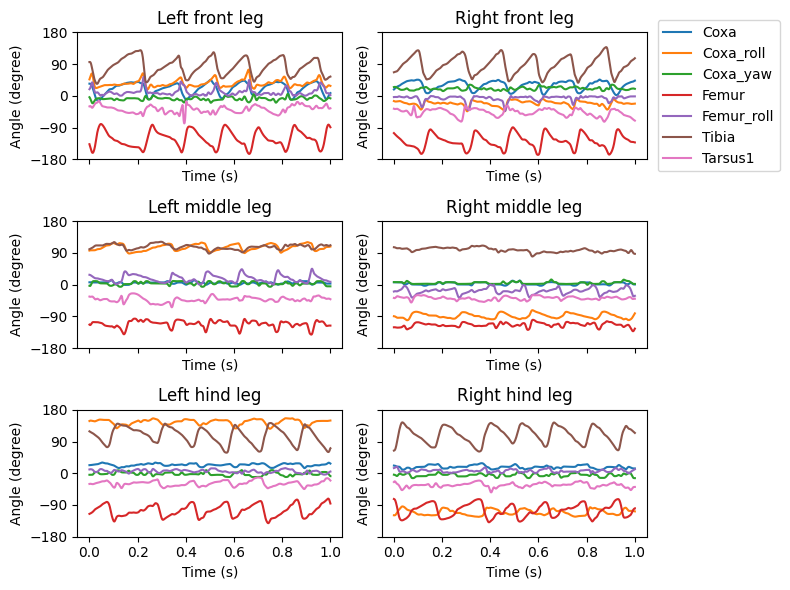

In [6]:
fig, axs = plt.subplots(
    3, 2, figsize=(8, 6), sharex=True, sharey=True, tight_layout=True
)
legs = [
    f"{side} {pos} leg"
    for pos in ["front", "middle", "hind"]
    for side in ["Left", "Right"]
]
for i, leg in enumerate(legs):
    ax = axs.flatten()[i]
    leg_code = f"{leg.split()[0][0]}{leg.split()[1][0]}".upper()
    for j, dof in enumerate(actuated_joints):
        if dof.split("_")[1][:2] != leg_code:
            continue
        ax.plot(output_t, np.rad2deg(data_block[j, :]), label=dof[8:])
    ax.set_ylim(-180, 180)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Angle (degree)")
    ax.set_yticks([-180, -90, 0, 90, 180])
    ax.set_title(leg)
    if leg == "Right front leg":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

Now we can create a NeuroMechFly simulation instance and play out the recorded kinematics in the MDP loop:

In [7]:
nmf = flygym.mujoco.NeuroMechFly(
    sim_params=sim_params,
    init_pose="stretch",
    actuated_joints=actuated_joints,
    control="position",
)
obs, info = nmf.reset()
for i in trange(target_num_steps):
    # here, we simply use the recorded joint angles as the target joint angles
    joint_pos = data_block[:, i]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

100%|██████████| 10000/10000 [00:19<00:00, 513.96it/s]


To save the rendered video:

In [8]:
nmf.save_video("./outputs/kinematic_replay.mp4")

In [9]:
from IPython.display import Video

Video("./outputs/kinematic_replay.mp4")

We can inspect the observation at the last step to see if they are consistent with our expectations:

In [10]:
for k, v in obs.items():
    print(f"{k}: shape {v.shape}")

joints: shape (3, 42)
fly: shape (4, 3)
contact_forces: shape (30, 3)
end_effectors: shape (6, 3)
fly_orientation: shape (3,)


The basic NeuroMechFly simulation always returns 0 as the reward. It always returns False for the `terminated` and `truncated` flags. The `info` is also empty. The user can extend the `NeuroMechFly` class to modify these behaviors.

In [11]:
print(f"reward: {reward}")
print(f"terminated: {terminated}")
print(f"truncated: {truncated}")
print(f"info: {info}")

reward: 0
terminated: False
truncated: False
info: {}


## Exercise 1: effects of simulation parameters

In this exercise, we will modify some simulation parameters to see their effects on *Drosophila* locomotion. For the description of simulation parameters, refer to https://neuromechfly.org/api_ref/parameters.html#flygym.mujoco.Parameters.

Modify the cell below to run the simulation with different values of `actuator_kp` (e.g., 10, 30 (default), 50). How does `actuator_kp` affect the walking behavior?

TODO:
The value of `actuator_kp` influence the run simulation, the smaller the value, the smaller the normal forces are and the bigger the value, the bigger those forces become.

In [19]:
sim_params_ = flygym.mujoco.Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.2,
    draw_contacts=True,
    # =========================================================================
    # TODO: # modify actuator_kp
    actuator_kp=1,
    # =========================================================================
)

nmf = flygym.mujoco.NeuroMechFly(
    sim_params=sim_params_,
    init_pose="stretch",
    actuated_joints=actuated_joints,
    control="position",
)
obs, info = nmf.reset()
for i in trange(target_num_steps):
    joint_pos = data_block[:, i]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

nmf.save_video("./outputs/kinematic_replay_actuator_kp_1.mp4")

100%|██████████| 10000/10000 [00:16<00:00, 593.89it/s]


In [20]:
Video("./outputs/kinematic_replay_actuator_kp_1.mp4")

Modify the simulation parameters to simulate the fly walking on a slippery surface.

Hint 1: Refer to the documentation of the `friction` parameter in [flygym.mujoco.Parameters](https://neuromechfly.org/api_ref/parameters.html#flygym.mujoco.Parameters) and [flygym.mujoco.arena.FlatTerrain](https://neuromechfly.org/api_ref/arena.html#flygym.mujoco.arena.FlatTerrain).

Hint 2: Setting the sliding friction coefficient to zero may lead to numerical errors. Use a small positive value (e.g., 2e-3) instead.

In [28]:
from flygym.mujoco.arena import FlatTerrain

sim_params = flygym.mujoco.Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.2,
    draw_contacts=True,
    # =========================================================================
    # TODO: add keyword argument to make the legs slippery
    friction=(2e-3,2e-3,2e-3)
    # =========================================================================
)

slippery_arena = FlatTerrain(
    # =========================================================================
    # TODO: add keyword argument to make the floor slippery
    friction=(2e-3,2e-3,2e-3)
    # =========================================================================
)

nmf = flygym.mujoco.NeuroMechFly(
    sim_params=sim_params,
    init_pose="stretch",
    actuated_joints=actuated_joints,
    control="position",
    arena=slippery_arena,
)

obs, info = nmf.reset()
for i in trange(target_num_steps):
    joint_pos = data_block[:, i]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

nmf.save_video("./outputs/kinematic_replay_slippery.mp4")

100%|██████████| 10000/10000 [00:23<00:00, 421.20it/s]


In [29]:
Video("./outputs/kinematic_replay_slippery.mp4")

Modify the simulation parameters to simulate the fly walking on floor with a 10° slope angle. The fly should struggle to walk forward initially and then fall backwards.
Visualize the fall by plotting the z-position of the fly over time.


Hint: Change the direction of the gravity. The fly should struggle to walk forward initially and then fall backwards.


100%|██████████| 10000/10000 [00:13<00:00, 731.07it/s]


Text(0, 0.5, 'z (mm)')

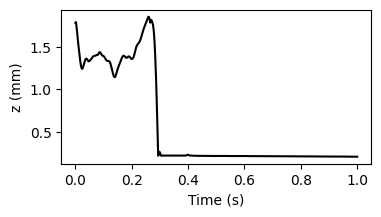

In [63]:
import math

# =============================================================================
# TODO: modify gravity
# should look something like
# gx = ...
# gz = ...
# gravity = (gx, 0, gz)

gx = -9.81e3*math.sin(math.radians(10))
gz = -9.81e3*math.cos(math.radians(10))
gravity = (gx, 0, gz)
# =============================================================================

sim_params_ = flygym.mujoco.Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.2,
    draw_contacts=True,
    gravity=gravity,
    align_camera_with_gravity=True,
)

nmf = flygym.mujoco.NeuroMechFly(
    sim_params=sim_params_,
    init_pose="stretch",
    actuated_joints=actuated_joints,
    control="position",
)
obs, info = nmf.reset()

z_positions = []

for i in trange(target_num_steps):
    joint_pos = data_block[:, i]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    # =========================================================================
    # TODO: get the z-position of the fly and append it to z_position
    z_position = obs['fly'][0][2]
    z_positions.append(z_position)
    # =========================================================================
    nmf.render()

nmf.save_video("./outputs/kinematic_replay_10deg.mp4")

# plot the z position of the fly over time
fig, ax = plt.subplots(figsize=(4, 2))
ax.plot(output_t, z_positions, color="k")
ax.set_xlabel("Time (s)")
ax.set_ylabel("z (mm)")

In [64]:
Video("./outputs/kinematic_replay_10deg.mp4")

## Exercise 2: extract kinematics for one step cycle

In this section, we will try to extract one complete the kinematics of one complete walking cycle, which can be repeated for an unlimited number of times to allow the fly to walk further. To accomplish this, we will locate the time interval for each walking cycle by detecting peaks in one of the joint angles, resample the kinematics of the walking cycles so that they are of the same length, and then average them.

In [70]:
import scipy
from scipy.signal import find_peaks

# get the joint angle of the right hind leg tibia
rh_tibia_angle = data_block[actuated_joints.index("joint_RHTibia")]

# ===============================================================================================
# TODO: detect peaks in the tibia angle of the right hind leg using scipy.signal.find_peaks
# see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html for usage
peak_frame_indices = find_peaks(rh_tibia_angle)[0]
# ===============================================================================================

cycle_n_frames = round(np.diff(peak_frame_indices).mean())

Text(0.5, 1.0, 'Right hind tibia')

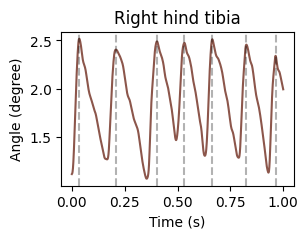

In [71]:
# plot the tibia angle of the right hind leg with detected peaks
fig, ax = plt.subplots(figsize=(3, 2))
ax.plot(output_t, rh_tibia_angle, color="C5")

for t in peak_frame_indices * sim_params.timestep:
    ax.axvline(t, color="k", ls="--", alpha=0.3)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Angle (degree)")
ax.set_title("Right hind tibia")

In [72]:
from scipy.interpolate import interp1d

data_block_cycle = np.zeros((len(actuated_joints), cycle_n_frames))

for a, b in np.lib.stride_tricks.sliding_window_view(peak_frame_indices, 2):
    old_indices = np.arange(b - a)
    new_indices = np.linspace(0, old_indices.max(), cycle_n_frames)
    data_block_cycle += interp1d(old_indices, data_block[:, a:b])(new_indices)

data_block_cycle /= len(peak_frame_indices) - 1

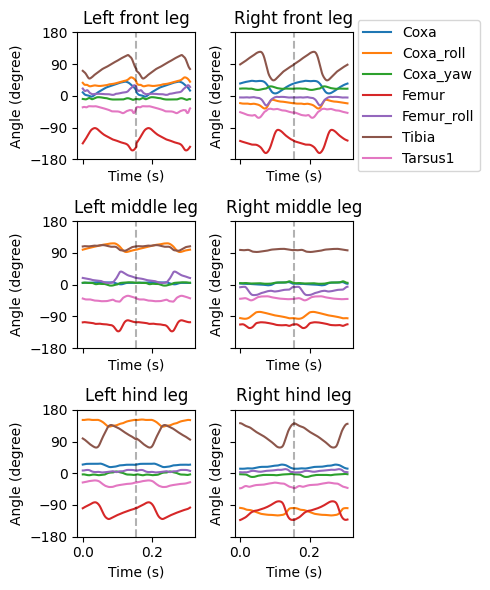

In [74]:
# plot locomotor kinematics for two cycles
fig, axs = plt.subplots(
    3, 2, figsize=(5, 6), sharex=True, sharey=True, tight_layout=True
)
legs = [
    f"{side} {pos} leg"
    for pos in ["front", "middle", "hind"]
    for side in ["Left", "Right"]
]
for i, leg in enumerate(legs):
    ax = axs.flatten()[i]
    leg_code = f"{leg.split()[0][0]}{leg.split()[1][0]}".upper()
    for j, dof in enumerate(actuated_joints):
        if dof.split("_")[1][:2] != leg_code:
            continue
        angles = np.tile(np.rad2deg(data_block_cycle[j, :]), 2)
        ax.plot(np.arange(len(angles)) * sim_params.timestep, angles, label=dof[8:])
    ax.set_ylim(-180, 180)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Angle (degree)")
    ax.set_yticks([-180, -90, 0, 90, 180])
    ax.set_title(leg)
    ax.axvline(cycle_n_frames * sim_params.timestep, color="k", ls="--", alpha=0.3)
    if leg == "Right front leg":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

In [75]:
# replay the locomotor kinematics for two cycles
sim_params_slow = flygym.mujoco.Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_playspeed=0.02,
    draw_contacts=False,
    render_camera="Animat/camera_left",
)

nmf = flygym.mujoco.NeuroMechFly(
    sim_params=sim_params_slow,
    init_pose="stretch",
    actuated_joints=actuated_joints,
    control="position",
)
obs, info = nmf.reset()
for i in trange(cycle_n_frames * 2):
    # here, we simply use the recorded joint angles as the target joint angles
    joint_pos = data_block_cycle[:, i % cycle_n_frames]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

nmf.save_video("./outputs/kinematic_replay_2_cycles.mp4")

100%|██████████| 3096/3096 [00:13<00:00, 234.18it/s]


# Exercise 3: alter locomotor kinematics


With the same simulation parameters and number of simulation steps, can you make the fly walk approximately twice as fast? (In *Drosophila*, changes in stance duration largely regulate walking speed, while stance amplitude and swing duration remain relatively constant (DeAngelis et al., 2019; Wosnitza et al., 2012). For simplicity, we will decrease both stance and swing durations here.)

In [88]:
nmf = flygym.mujoco.NeuroMechFly(
    sim_params=sim_params,
    init_pose="stretch",
    actuated_joints=actuated_joints,
    control="position",
)
obs, info = nmf.reset()
for i in trange(target_num_steps):
    # =========================================================================
    # TODO: replay the locomotor kinematics at 2× speed by skipping frames
    # you will find the data_block_cycle and cycle_n_frames variables useful
    joint_pos = data_block_cycle[:, i*2 % cycle_n_frames]
    # =========================================================================
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

nmf.save_video("./outputs/kinematic_replay_fast.mp4")

100%|██████████| 10000/10000 [00:16<00:00, 609.01it/s]


In [89]:
Video("./outputs/kinematic_replay_fast.mp4")

(Optional) Can you make the fly backwards? 

In [106]:
data_block_backwards = data_block_cycle.copy()

# =============================================================================
# TODO: modify the data_block_backwards to make the fly walk backwards
for i in range(len(data_block_backwards)):
    data_block_backwards[i] = data_block_backwards[i][::-1]
# =============================================================================

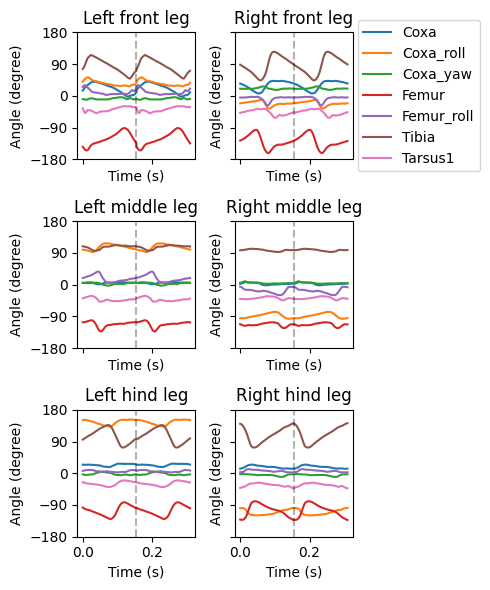

In [107]:
# plot locomotor kinematics for two cycles
fig, axs = plt.subplots(
    3, 2, figsize=(5, 6), sharex=True, sharey=True, tight_layout=True
)
legs = [
    f"{side} {pos} leg"
    for pos in ["front", "middle", "hind"]
    for side in ["Left", "Right"]
]
for i, leg in enumerate(legs):
    ax = axs.flatten()[i]
    leg_code = f"{leg.split()[0][0]}{leg.split()[1][0]}".upper()
    for j, dof in enumerate(actuated_joints):
        if dof.split("_")[1][:2] != leg_code:
            continue
        angles = np.tile(np.rad2deg(data_block_backwards[j, :]), 2)
        ax.plot(np.arange(len(angles)) * sim_params.timestep, angles, label=dof[8:])
    ax.set_ylim(-180, 180)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Angle (degree)")
    ax.set_yticks([-180, -90, 0, 90, 180])
    ax.set_title(leg)
    ax.axvline(cycle_n_frames * sim_params.timestep, color="k", ls="--", alpha=0.3)
    if leg == "Right front leg":
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

In [108]:
nmf = flygym.mujoco.NeuroMechFly(
    sim_params=sim_params,
    init_pose="stretch",
    actuated_joints=actuated_joints,
    control="position",
)
obs, info = nmf.reset()
for i in trange(target_num_steps):
    joint_pos = data_block_backwards[:, i % cycle_n_frames]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

nmf.save_video("./outputs/kinematic_replay_backwards.mp4")

100%|██████████| 10000/10000 [00:16<00:00, 622.18it/s]


In [109]:
Video("./outputs/kinematic_replay_backwards.mp4")